## FROM THE COURSE PAGE (DELETE AT THE END):
The notebook is where we go to check exactly what you did to get your analysis. The notebook should be a pleasant read: Please structure it nicely with clear headlines of what cells make what figures, etc. Also, put in enough text to ensure that a fellow student taking this class could understand exactly what you are doing in the present cell, and why you are doing it like this.

Please also add the following further details about your data and analysis,

Write in more detail about your choices in data cleaning and preprocessing
Did you do analyses / calculate statistics that didn't make it to the main text, put them here, but clearly mark that these did not make it into the main text.


# CLIMATE CHANGE, A GLOBAL CHALLENGE OF OUR TIME

Laura Casanovas I Buliart (s2227980), Mariangeles (), Zahra Soleimani (s170422)

In this project we eplore a set of Tweets that talk about climate change and its metadata to see if there are any common sentiment between communities or topics. 

## 0. Requirements

In [1]:
# Standard Libraries
import os
import re
from datetime import datetime
from itertools import combinations
from collections import defaultdict
from math import sqrt

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import geopandas as gpd

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.probability import FreqDist

# Text and Document Processing
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
import gensim

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

# Network Analysis
import networkx as nx
import community as community_louvain

# Statistical Analysis
from scipy.stats import chi2_contingency

# Miscellaneous
import random
from multiprocessing import Pool
import itertools
import requests

# Downloading NLTK resources
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

C:\Users\Lau\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lau\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#!pip install python-louvain

## 1. Loading data

In [3]:
# This file was created by using different datasets
file_path = 'Tweets_with_location.csv'

# Read the file
try:
    tweets_df = pd.read_csv(file_path, encoding='ISO-8859-1')
except Exception as e:
    error = str(e)

# Check if the file was successfully read or report the error
if 'tweets_df' in locals():
    success = True
    preview = tweets_df.head()
else:
    success = False
    preview = error

#success, preview

# Display the first few rows of the dataframe
tweets_df.head()

Name        UserName             Time  \
0    Gerald Butts         gmbutts  1/24/2022 22:24   
1    Gerald Butts         gmbutts  1/24/2022 22:27   
2    Abigail Boyd  AbigailBoydMLC   3/7/2022 23:46   
3  Warren Gunnels   GunnelsWarren  2/22/2022 23:49   
4        Scalawag     scalawagmag  3/21/2022 21:45   

                                                Text   Likes  Retweets  \
0  I'm glad serious researchers are taking up thi...    17.0      50.0   
1  1. Partisan adhesion in Canada is weak and par...     2.0      31.0   
2  Minister Ayers, what are you doing to assist t...     8.0      12.0   
3  I want cable news to cover the child poverty r...  5418.0  203000.0   
4  "If we don't adapt the internet to the reality...     1.0       9.0   

                                            TweetURL  \
0  https://twitter.com/gmbutts/status/14857402380...   
1  https://twitter.com/gmbutts/status/14857409939...   
2  https://twitter.com/AbigailBoydMLC/status/1500...   
3  https://twitter.com/GunnelsWarren/status/14962...   
4  https://twitter.com/scalawagmag/status/1506024...   

                              UserURL City Country  Unnamed: 10  Unnamed: 11  
0         https://twitter.com/gmbutts    0       0          NaN          NaN  
1         https://twitter.com/gmbutts    0       0          NaN          NaN  
2  https://twitter.com/AbigailBoydMLC    0       0          NaN          NaN  
3   https://twitter.com/GunnelsWarren    0       0          NaN          NaN  
4     https://twitter.com/scalawagmag    0       0          NaN          NaN

## 2. Required functions

### 2.1 Data Preprocessing

In [4]:
def remove_irrelevant_columns(df, columns_to_remove):
    """Remove irrelevant columns from the dataframe."""
    df = df.drop(columns=columns_to_remove, errors='ignore')
    return df

def handle_missing_values(df, columns):
    """Handle missing or placeholder values in specified columns."""
    for column in columns:
        # '0' is a placeholder for missing data
        df[column] = df[column].replace('0', None)
    return df

def convert_to_datetime(df, column):
    """Convert a column to datetime format."""
    df[column] = pd.to_datetime(df[column], errors='coerce')
    return df

def clean_text_data(df, text_column):
    """Clean the text data in a specified column."""
    def clean_text(text):
        if not isinstance(text, str):
            return text  # Return the original value if it's not a string
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove special characters and numbers
        text = re.sub(r'[^A-Za-z ]+', '', text)
        return text.strip()

    df[text_column] = df[text_column].apply(clean_text)
    return df


def preprocess_text(text):
    if not isinstance(text, str):
        return []
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    return [word for word in words if word not in stop_words and word.isalpha()]

def clean_text_word_cloud(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return []

    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove punctuation and convert to lower case
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Remove stopwords and additional removable characters
    tokens = [word for word in tokens if word not in stop_words and word not in list_removable]
    return tokens

### 2.2 Text Analysis

#### 2.2.1 General

In [5]:
# Function to extract hashtags
def extract_hashtags_simple(text):
    return re.findall(r'#\w+', text)

# Function to extract hashtags from a tweet, with a check for non-string values
def extract_hashtags(text):
    if not isinstance(text, str):
        return []
    hashtags = re.findall(r"#(\w+)", text)
    return list(map(lambda x: x.lower(),set(hashtags)))

# Function to combine text for each city
def combine_text_for_city(city):
    return ' '.join(tweets_df[tweets_df.City == city]['cleaned_text'].dropna().astype(str))

#### 2.2.2 Topic Analysis

In [6]:
# Perform LDA Topic Modeling
def perform_lda(text_data, num_topics=5):
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    topics = lda_model.print_topics(num_words=4)
    return lda_model, topics  # Return both the model and the topics

# Function to assign the most probable topic to each tweet
def assign_topics(lda_model, corpus):
    topic_numbers = []
    for doc in corpus:
        topics = lda_model.get_document_topics(doc)
        topic_numbers.append(sorted(topics, key=lambda x: x[1], reverse=True)[0][0])
    return topic_numbers

#### 2.2.3 Sentiment Analysis

In [7]:
# Define the Sentiment Analysis Function
def analyze_sentiment(text):
    """Analyze the sentiment of the given text."""
    if not isinstance(text, str):
        return {"neg": 0, "neu": 0, "pos": 0, "compound": 0}  # Return neutral sentiment for non-string inputs
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

### 2.3 Graph Analysis

In [8]:
def detect_communities_louvain(G,resolution=1.0):
    """
    Detect communities in a graph using the Louvain algorithm.
    """
    # Apply the Louvain algorithm
    partition = community_louvain.best_partition(G,resolution=resolution)

    return partition

def plot_graph_with_communities(G, partition):
    """
    Plot the graph with different colors for different communities using a force-directed layout.
    """
    pos = nx.circular_layout(G)  # This is similar to Force Atlas
    cmap = plt.get_cmap('viridis')
    colors = [partition.get(node, 0) for node in G.nodes()]
    
    # Create a figure and axis
    plt.figure(figsize=(12, 12))
    ax = plt.gca()

    nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=cmap, node_size=100,ax=ax)
    nx.draw_networkx_edges(G, pos,ax=ax)
    
    plt.show()

def plot_graph_with_forceatlas2(G,partition):
    cmap = plt.get_cmap('Set2')
    colors = [partition.get(node, 0) for node in G.nodes()]  # Use 'get' to avoid KeyError

    # Convert the networkx graph to a scipy sparse array
    sparse_matrix = nx.to_scipy_sparse_array(G, dtype=np.float32)

    # Convert the sparse array to a sparse matrix
    sparse_matrix = csr_matrix(sparse_matrix)

    # Initialize the Force Atlas 2 layout algorithm
    forceatlas2 =  ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=3, #lower scalingRatio makes a more spares graph
                        strongGravityMode=True,
                        gravity=0.05, #low gravity makes the graph more spread out

                        # Log
                        verbose=False)

    # Since we cannot use forceatlas2_networkx_layout, let's use forceatlas2 directly
    positions = forceatlas2.forceatlas2(sparse_matrix, iterations=1000)

    # Node list from the graph
    nodes_list = list(G.nodes())

    # Convert the positions to a format that can be used by networkx for drawing
    positions_dict = {nodes_list[node]: position for node, position in enumerate(positions)}


    # Draw the graph using the Force Atlas 2 layout
    plt.figure(figsize=(15, 15))
    ax = plt.gca()
   

    node_size = [degree * 2 for node, degree in G.degree()]

    nx.draw_networkx_nodes(G, positions_dict,node_size=node_size, node_color=colors, cmap=cmap,  ax=ax)
    nx.draw_networkx_edges(G, positions_dict, alpha=0.2,ax=ax,edge_color='lightsteelblue')

    ax.set_title('Communities in the Network')
    plt.axis('off')
    plt.show()  
    
# Function to map hashtags to communities
def map_to_community(hashtags):
    communities = []
    for hashtag in hashtags:
        matching_rows = partition_df[partition_df['Hashtag'] == hashtag]
        if not matching_rows.empty:
            communities.append(matching_rows['Community'].values[0])
        else:
            # Handle the case where no matching rows are found
            communities.append(None)  # You can use a placeholder value or handle it as needed
    return communities

## 3. Data cleaning and data augmentation

In [9]:
# Applying the functions to the dataset
tweets_cleaned = tweets_df.copy()
tweets_cleaned['Text'] = tweets_cleaned['Text'].astype(str)
tweets_cleaned = tweets_cleaned[tweets_cleaned['Text'].notna()]

# Extract hashtags 
tweets_cleaned['Original_Text'] = tweets_cleaned['Text']
tweets_cleaned['Hashtags'] = tweets_cleaned['Original_Text'].apply(extract_hashtags_simple)
# Keep only the string without the hashtag
tweets_cleaned['Hashtags'] = tweets_cleaned['Hashtags'].apply(lambda hashtags: [tag.lower()[1:] for tag in hashtags])

tweets_cleaned = remove_irrelevant_columns(tweets_cleaned, ['Unnamed: 10', 'Unnamed: 11'])
tweets_cleaned = handle_missing_values(tweets_cleaned, ['City', 'Country'])
tweets_cleaned = convert_to_datetime(tweets_cleaned, 'Time')
tweets_cleaned = clean_text_data(tweets_cleaned, 'Text')

# Displaying the first few rows of the cleaned dataframe
tweets_cleaned.head()

Name        UserName                Time  \
0    Gerald Butts         gmbutts 2022-01-24 22:24:00   
1    Gerald Butts         gmbutts 2022-01-24 22:27:00   
2    Abigail Boyd  AbigailBoydMLC 2022-03-07 23:46:00   
3  Warren Gunnels   GunnelsWarren 2022-02-22 23:49:00   
4        Scalawag     scalawagmag 2022-03-21 21:45:00   

                                                Text   Likes  Retweets  \
0  Im glad serious researchers are taking up this...    17.0      50.0   
1  Partisan adhesion in Canada is weak and partly...     2.0      31.0   
2  Minister Ayers what are you doing to assist th...     8.0      12.0   
3  I want cable news to cover the child poverty r...  5418.0  203000.0   
4  If we dont adapt the internet to the reality o...     1.0       9.0   

                                            TweetURL  \
0  https://twitter.com/gmbutts/status/14857402380...   
1  https://twitter.com/gmbutts/status/14857409939...   
2  https://twitter.com/AbigailBoydMLC/status/1500...   
3  https://twitter.com/GunnelsWarren/status/14962...   
4  https://twitter.com/scalawagmag/status/1506024...   

                              UserURL  City Country  \
0         https://twitter.com/gmbutts  None    None   
1         https://twitter.com/gmbutts  None    None   
2  https://twitter.com/AbigailBoydMLC  None    None   
3   https://twitter.com/GunnelsWarren  None    None   
4     https://twitter.com/scalawagmag  None    None   

                                       Original_Text Hashtags  
0  I'm glad serious researchers are taking up thi...       []  
1  1. Partisan adhesion in Canada is weak and par...       []  
2  Minister Ayers, what are you doing to assist t...       []  
3  I want cable news to cover the child poverty r...       []  
4  "If we don't adapt the internet to the reality...       []

## 4. Data Exploration

### 4.1 Basic Analysis

In [10]:
# Basic Statistics
num_tweets = tweets_cleaned.shape[0]
num_unique_users = tweets_cleaned['UserName'].nunique()
most_active_users = tweets_cleaned['UserName'].value_counts().head(5)
most_liked_tweet = tweets_cleaned.loc[tweets_cleaned['Likes'].idxmax()]
most_retweeted_tweet = tweets_cleaned.loc[tweets_cleaned['Retweets'].idxmax()]

basic_statistics = {
    "Number of Tweets": num_tweets,
    "Number of Unique Users": num_unique_users,
    "Most Active Users": most_active_users,
    "Most Liked Tweet": most_liked_tweet[['UserName', 'Text', 'Likes']],
    "Most Retweeted Tweet": most_retweeted_tweet[['UserName', 'Text', 'Retweets']]
}

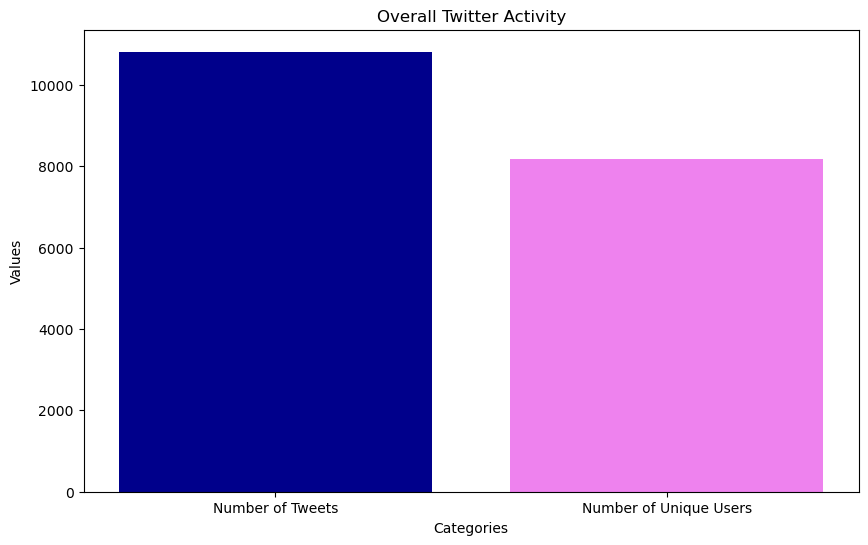

In [11]:
# Bar chart for overall statistics
categories = ["Number of Tweets", "Number of Unique Users"]
values = [num_tweets, num_unique_users]

plt.figure(figsize=(10, 6))
plt.bar(categories, values, color=['darkblue', 'violet'])
plt.title('Overall Twitter Activity')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.show()

This figure shows that many users participated in this dataset. Nonetheless, to check if the dataset is being dominated by one user or many participate in similar manner we need to do a user engagement analysis. 

### 4.2 User engagement analysis

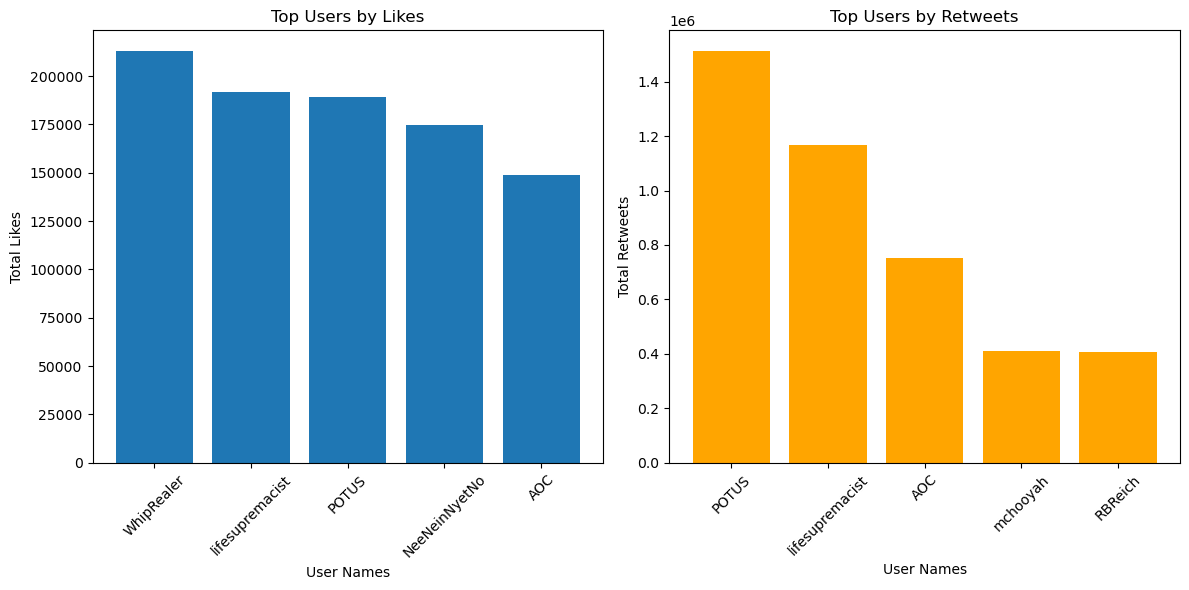

In [12]:
# Top Engaged Users based on Likes and Retweets
top_users_likes = tweets_cleaned.groupby('UserName')['Likes'].sum().sort_values(ascending=False).head(5)
top_users_retweets = tweets_cleaned.groupby('UserName')['Retweets'].sum().sort_values(ascending=False).head(5)

# Displaying the top engaged users based on likes and retweets
top_engaged_users = {
    "Top Users by Likes": top_users_likes,
    "Top Users by Retweets": top_users_retweets
}

# Create a figure and axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Bar plot for Top Users by Likes
axes[0].bar(top_engaged_users["Top Users by Likes"].index, top_engaged_users["Top Users by Likes"])
axes[0].set_title("Top Users by Likes")
axes[0].set_xlabel("User Names")
axes[0].set_ylabel("Total Likes")

# Bar plot for Top Users by Retweets
axes[1].bar(top_engaged_users["Top Users by Retweets"].index, top_engaged_users["Top Users by Retweets"], color='orange')
axes[1].set_title("Top Users by Retweets")
axes[1].set_xlabel("User Names")
axes[1].set_ylabel("Total Retweets")

# Rotate x-axis labels for better readability
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

This analysis shows us that diverse range of users participated in a similar way, rather than being dominated by only one user. Therefore, the dataset is not biased in this sense.

In [13]:
# Extracting a few of the most liked and retweeted tweets for content analysis
most_liked_tweets_content = tweets_cleaned.loc[tweets_cleaned['Likes'].nlargest(5).index]
most_retweeted_tweets_content = tweets_cleaned.loc[tweets_cleaned['Retweets'].nlargest(5).index]

# Displaying the content of these tweets
most_engaged_tweets_content = {
    "Most Liked Tweets Content": most_liked_tweets_content[['UserName', 'Text', 'Likes']],
    "Most Retweeted Tweets Content": most_retweeted_tweets_content[['UserName', 'Text', 'Retweets']]
}

print('\033[1m' + 'Most Liked Tweets\n' + '\033[0m')
most_liked_tweets_text= most_engaged_tweets_content['Most Liked Tweets Content'].Text
for idx, text in most_liked_tweets_text.iteritems():
    print(f"{idx} - {text}")
    print('\n')

    
    
print('\033[1m' + '\n\nMost Retweeted Tweets\n' + '\033[0m')
most_retweet_tweets_text= most_engaged_tweets_content['Most Retweeted Tweets Content'].Text
for idx, text in most_retweet_tweets_text.iteritems():
    print(f"{idx} - {text}")
    print('\n')

Most Liked Tweets

9414 - Its a farce Always has been Always will be Climate change generates dollars Thats what its forKK


8876 - A gathering of white people on colonized land watching a wave approaching that has the power to take them out and not moving until it is too late is the perfect metaphor for climate changeFrom Kaniela IngKK


5580 - Congratulations to EmmanuelMacron on his reelection France is our oldest ally and a key partner in addressing global challenges I look forward to our continued close cooperation  including on supporting Ukraine defending democracy and countering climate changeKK


2661 - Crazy how a guy self immolates in the countrys capital in front of the Supreme Court on Earth Day in protest of climate change inaction and its barely a blip on the media and social radarKK


4787 - Universal healthcare and childcare Gun safety Combating climate changeThe GOP opposes it all If they refuse to support life after birth how can they claim to believe in it beforeTru

### 4.3 Temporal analysis

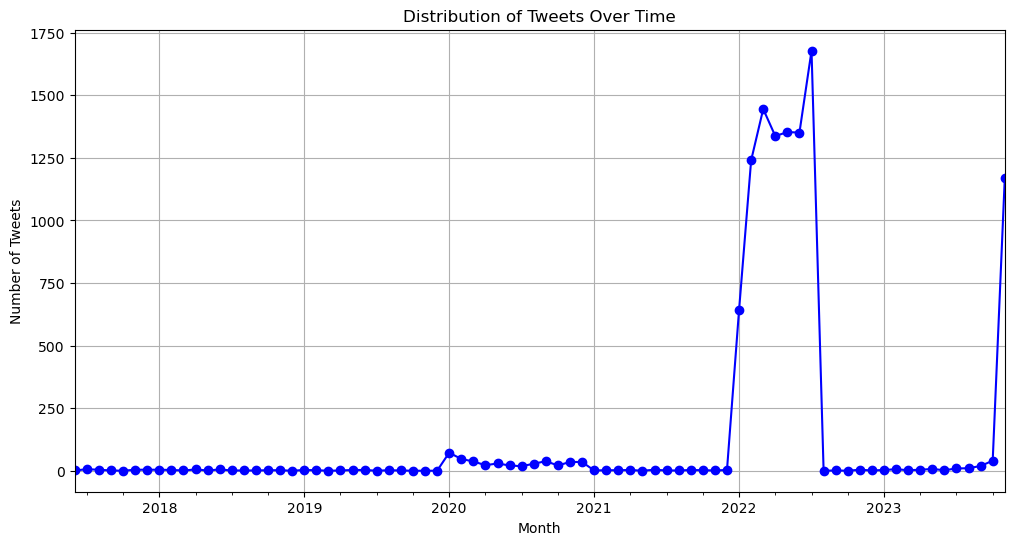

In [14]:
# Add year variable
tweets_cleaned['year'] = tweets_cleaned['Time'].dt.year
# Temporal Analysis: Distribution of tweets over time
tweets_cleaned.set_index('Time', inplace=True)

# Resampling to get tweet counts per month
monthly_tweets = tweets_cleaned.resample('M').size()

# Plotting
plt.figure(figsize=(12, 6))
monthly_tweets.plot(kind='line', color='blue', marker='o')
plt.title('Distribution of Tweets Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()

In this plot we realize that most of the tweets from our dataset are from 2022 and 2023. Therefore, we have decided to focus exclusively on tweets from these two years for the remainder of our analysis. This temporal restriction allows us to hone in on the most recent and relevant data, aligning our investigation with the contemporary discourse surrounding climate change on Twitter.

In [15]:
tweets_cleaned = tweets_cleaned[(tweets_cleaned['year']==2022) |(tweets_cleaned['year']==2023)]

## 5. Natural Language Processing Analysis

### 5.1 Topic Analysis

In [16]:
# Preprocess the Text:
tweets_cleaned['Processed_Text'] = tweets_cleaned['Text'].apply(preprocess_text)

# Applying LDA topic modeling
tweets_preprocessed = tweets_cleaned['Processed_Text']
lda_model, topics = perform_lda(tweets_preprocessed)  # Capture both outputs

# Print summarized topics
print("Summarized Topics:")
for topic in topics:
    print(topic)

# Print detailed topics
num_topics = 5  # number of topics
words_per_topic = 10  # number of words to display per topic

print("\nDetailed Topics:")
for i in range(num_topics):
    words = lda_model.show_topic(i, topn=words_per_topic)
    topic_words = ", ".join([word for word, prob in words])
    print(f"Topic {i}: {topic_words}")

Summarized Topics:
(0, '0.045*"climate" + 0.041*"change" + 0.011*"replying" + 0.007*"people"')
(1, '0.024*"climatechange" + 0.014*"help" + 0.013*"emirates" + 0.013*"climate"')
(2, '0.009*"climate" + 0.008*"change" + 0.007*"climatechange" + 0.004*"replying"')
(3, '0.052*"climate" + 0.040*"change" + 0.006*"new" + 0.005*"climatechange"')
(4, '0.029*"climate" + 0.024*"change" + 0.009*"climatechange" + 0.006*"global"')

Detailed Topics:
Topic 0: climate, change, replying, people, dont, years, like, us, much, want
Topic 1: climatechange, help, emirates, climate, fund, share, fair, lossanddamage, paying, hit
Topic 2: climate, change, climatechange, replying, net, action, zero, energy, word, live
Topic 3: climate, change, new, climatechange, us, fossil, emissions, one, people, energy
Topic 4: climate, change, climatechange, global, learn, food, impact, security, environmental, water


In [17]:
# 'tweets_preprocessed' contains the preprocessed text data
dictionary = corpora.Dictionary(tweets_preprocessed)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tweets_preprocessed]

lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics=5, id2word=dictionary, passes=15)


tweets_cleaned['Topic'] = assign_topics(lda_model, doc_term_matrix)

# Assign a topic number to each tweet
tweets_cleaned['Topic'] = assign_topics(lda_model, doc_term_matrix)

# Now apply the mapping
topic_names = {
    0: "Global Climate Challenges",
    1: "Climate Change Discourse",
    2: "Environmental Emissions and Energy",
    3: "Climate Justice and Responsibility",
    4: "Climate Debate and Controversy"
}

tweets_cleaned['Topic_Name'] = tweets_cleaned['Topic'].map(topic_names)

# Display the first few rows to verify the topic names are added
print(tweets_cleaned[['Text', 'Topic', 'Topic_Name']].head())

                                                                  Text  Topic  \
Time                                                                            
2022-01-24 22:24:00  Im glad serious researchers are taking up this...      1   
2022-01-24 22:27:00  Partisan adhesion in Canada is weak and partly...      2   
2022-03-07 23:46:00  Minister Ayers what are you doing to assist th...      0   
2022-02-22 23:49:00  I want cable news to cover the child poverty r...      1   
2022-03-21 21:45:00  If we dont adapt the internet to the reality o...      0   

                                             Topic_Name  
Time                                                     
2022-01-24 22:24:00            Climate Change Discourse  
2022-01-24 22:27:00  Environmental Emissions and Energy  
2022-03-07 23:46:00           Global Climate Challenges  
2022-02-22 23:49:00            Climate Change Discourse  
2022-03-21 21:45:00           Global Climate Challenges  


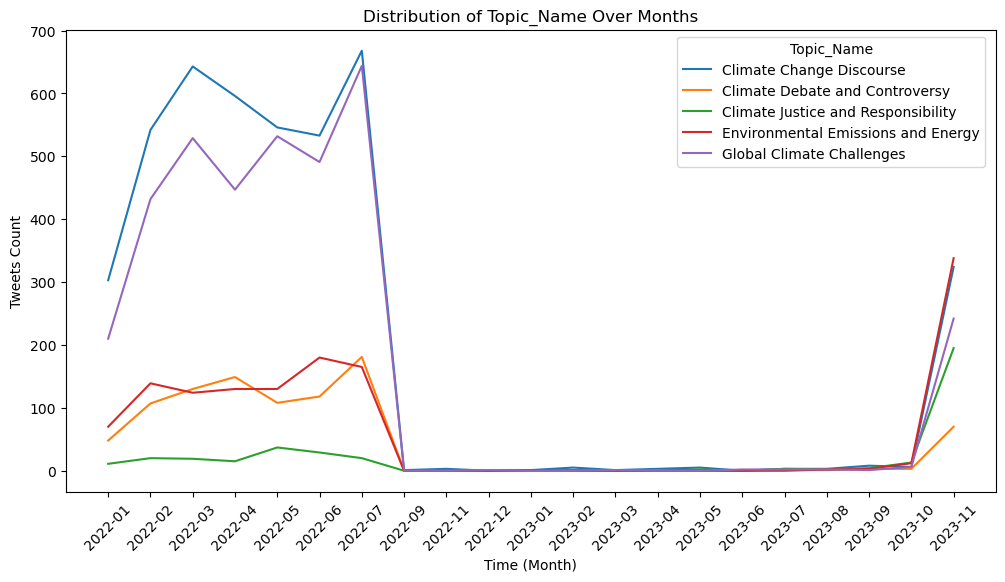

In [18]:
# Group by month and Topic_Name, then count occurrences
grouped_df = tweets_cleaned.groupby([tweets_cleaned.index.to_period('M'), 'Topic_Name']).size().unstack(fill_value=0)

# Convert Period index to string representation of the month
grouped_df.index = grouped_df.index.strftime('%Y-%m')

# Plotting
plt.figure(figsize=(12, 6))

# Loop through each 'Topic_Name' and plot a line
for column in grouped_df.columns:
    plt.plot(grouped_df.index, grouped_df[column], label=column)

plt.title('Distribution of Topic_Name Over Months')
plt.xlabel('Time (Month)')
plt.xticks(rotation=45)
plt.ylabel('Tweets Count')
# Adjust the legend position to upper left
plt.legend(title='Topic_Name', bbox_to_anchor=(0.65, 1), loc='upper left')


# Display the plot
plt.show()

### 5.2 Sentiment Analysis

In [19]:
# Apply the Function to the Tweets
tweets_cleaned['Sentiment'] = tweets_cleaned['Text'].apply(analyze_sentiment)

# Display the Results
tweets_cleaned[['Text', 'Sentiment']].head()

Text  \
Time                                                                     
2022-01-24 22:24:00  Im glad serious researchers are taking up this...   
2022-01-24 22:27:00  Partisan adhesion in Canada is weak and partly...   
2022-03-07 23:46:00  Minister Ayers what are you doing to assist th...   
2022-02-22 23:49:00  I want cable news to cover the child poverty r...   
2022-03-21 21:45:00  If we dont adapt the internet to the reality o...   

                                                             Sentiment  
Time                                                                    
2022-01-24 22:24:00  {'neg': 0.039, 'neu': 0.7, 'pos': 0.261, 'comp...  
2022-01-24 22:27:00  {'neg': 0.148, 'neu': 0.759, 'pos': 0.094, 'co...  
2022-03-07 23:46:00  {'neg': 0.055, 'neu': 0.824, 'pos': 0.122, 'co...  
2022-02-22 23:49:00  {'neg': 0.179, 'neu': 0.728, 'pos': 0.093, 'co...  
2022-03-21 21:45:00  {'neg': 0.051, 'neu': 0.87, 'pos': 0.078, 'com...

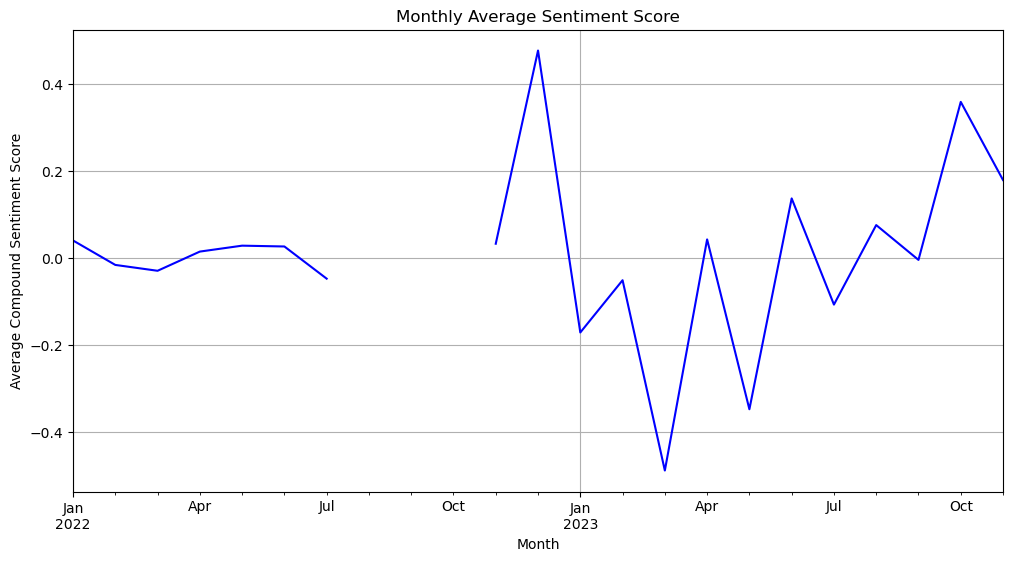

In [20]:
# Extract the compound sentiment score
tweets_cleaned['Compound_Score'] = tweets_cleaned['Sentiment'].apply(lambda x: x['compound'])

# Ensure 'Time' is set as the index and in datetime format
tweets_cleaned.index = pd.to_datetime(tweets_cleaned.index)

# Resample and calculate the average compound score monthly
monthly_sentiment = tweets_cleaned['Compound_Score'].resample('M').mean()

# Plotting the monthly average sentiment score
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(kind='line', color='blue')
plt.title('Monthly Average Sentiment Score')
plt.xlabel('Month')
plt.ylabel('Average Compound Sentiment Score')
plt.grid(True)
plt.show()

In [21]:
# Extracting values for each key
tweets_cleaned['Sentiment_negative_socre'] = tweets_cleaned['Sentiment'].apply(lambda x: x.get('neg'))
tweets_cleaned['Sentiment_neutral_socre'] = tweets_cleaned['Sentiment'].apply(lambda x: x.get('neu'))
tweets_cleaned['Sentiment_positive_socre'] = tweets_cleaned['Sentiment'].apply(lambda x: x.get('pos'))
tweets_cleaned['Total_sentiment'] = tweets_cleaned['Sentiment'].apply(lambda x: x.get('compound'))

# Drop the original 'Sentiment' column if needed
tweets_cleaned = tweets_cleaned.drop(columns=['Sentiment'])

## 6. Geographical Analysis 

In [22]:
# Checking the contents of the 'City' and 'Country' columns
city_data_preview = tweets_cleaned['City'].value_counts().head()
country_data_preview = tweets_cleaned['Country'].value_counts().head()

# Standardizing country names
tweets_cleaned['Country'] = tweets_cleaned['Country'].replace({'CA': 'Canada', 'NY': 'United States'})

# Handling missing values (if any)
tweets_cleaned['City'].fillna('Unknown', inplace=True)
tweets_cleaned['Country'].fillna('Unknown', inplace=True)

# Aggregating Tweets by Location
city_counts = tweets_cleaned['City'].value_counts()
country_counts = tweets_cleaned['Country'].value_counts()

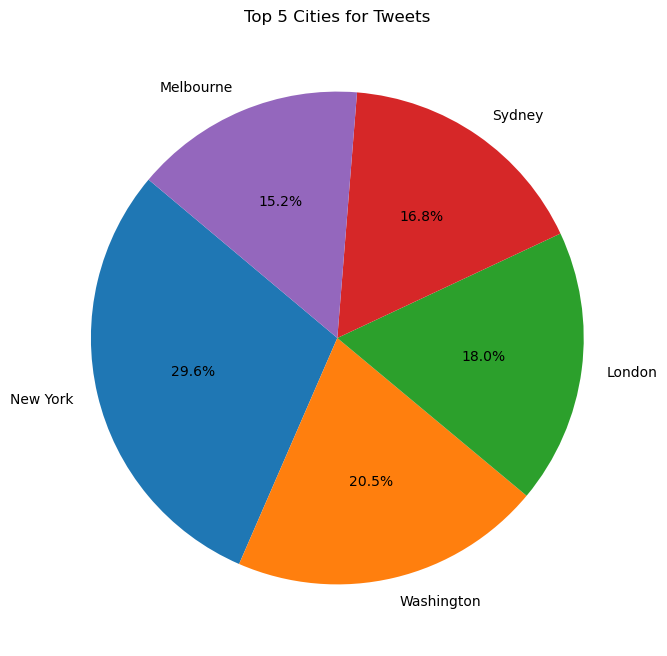

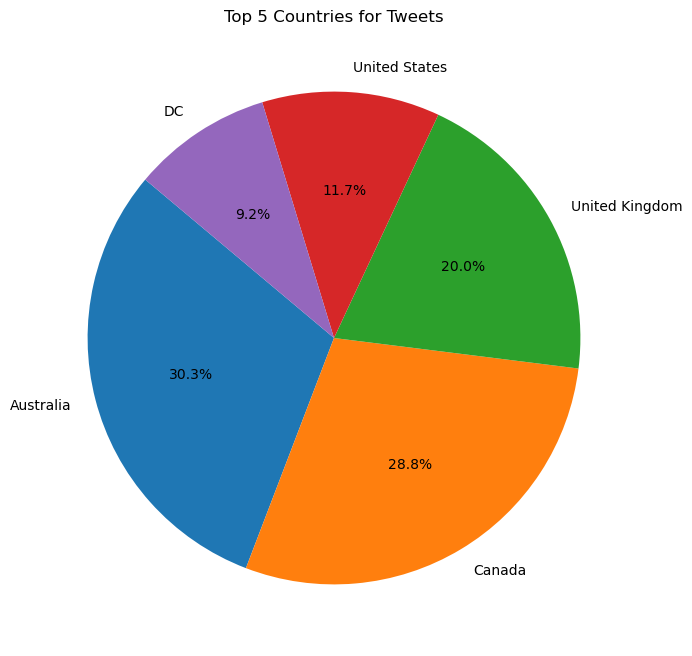

In [23]:
# Check and drop '0' from city_counts if it exists
if '0' in city_counts.index:
    city_counts = city_counts.drop('0')

# Check and drop 'Unknown' from city_counts if it exists
if 'Unknown' in city_counts.index:
    city_counts = city_counts.drop('Unknown')

# Now directly select the top 5 cities
top_cities = city_counts.head(5)

# Similarly, check and drop 'Unknown' from country_counts if it exists
if 'Unknown' in country_counts.index:
    country_counts = country_counts.drop('Unknown')

# Now directly select the top 5 countries
top_countries = country_counts.head(5)

# Proceed with plotting for top cities and countries
plt.figure(figsize=(8, 8))
top_cities.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Cities for Tweets')
plt.ylabel('')  # Hide the y-label

plt.figure(figsize=(8, 8))
top_countries.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Countries for Tweets')
plt.ylabel('')  # Hide the y-label

plt.show()

In [24]:
# Inspect Location Data, Checking the contents of the 'City' and 'Country' columns
city_data_preview = tweets_cleaned['City'].value_counts().head()
country_data_preview = tweets_cleaned['Country'].value_counts().head()

In [25]:
# Standardizing country names
tweets_cleaned['Country'] = tweets_cleaned['Country'].replace({'CA': 'Canada', 'NY': 'United States'})

# Handling missing values
tweets_cleaned['City'].fillna('Unknown', inplace=True)
tweets_cleaned['Country'].fillna('Unknown', inplace=True)

In [26]:
# Aggregating Tweets by Location

city_counts = tweets_cleaned['City'].value_counts()
country_counts = tweets_cleaned['Country'].value_counts()

print("Top Cities for Climate Change Tweets:")
print(city_counts.head())  # Display top 5 cities

print("\nTop Countries for Climate Change Tweets:")
print(country_counts.head())  # Display top 5 countries

Top Cities for Climate Change Tweets:
Unknown       6762
New York       279
Washington     193
London         170
Sydney         158
Name: City, dtype: int64

Top Countries for Climate Change Tweets:
Unknown           5217
Australia          917
Canada             873
United Kingdom     606
United States      353
Name: Country, dtype: int64


We have too few cities, hence we will focus in countries. 

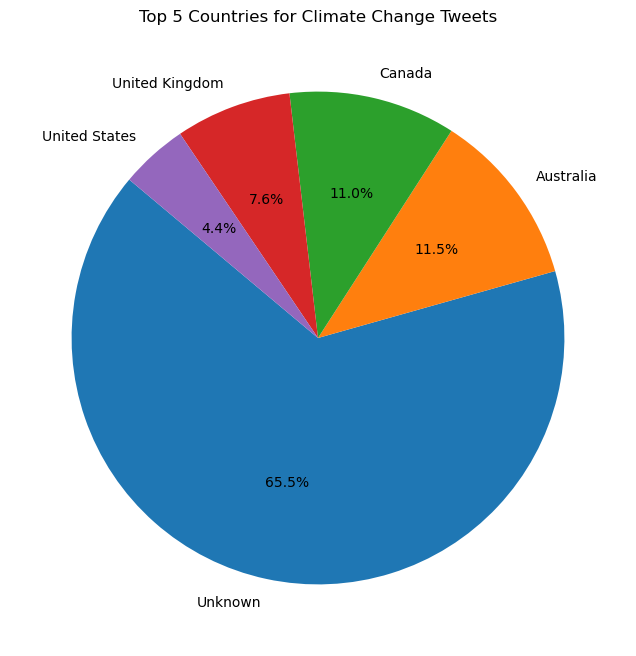

In [27]:
# Selecting the top 5 countries
top_countries = tweets_cleaned['Country'].value_counts().head(5)

# Plotting
top_countries.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), startangle=140)
plt.title('Top 5 Countries for Climate Change Tweets')
plt.ylabel('')  # Hide the y-label
plt.show()

Let's see what does each country tweet about

In [28]:
# Get unique topics and years in the dataset
topics = tweets_cleaned['Topic_Name'].unique()
tweets_cleaned = tweets_cleaned[tweets_cleaned.index.notnull()]
tweets_cleaned['year'] = tweets_cleaned.index.year
years = tweets_cleaned['year'].unique()


#Loop through each topic and each year and create a separate map
for topic in topics:
    for year in years:
        
        # Filter data for the current topic and year
        topic_year_data = tweets_cleaned[(tweets_cleaned['Topic_Name'] == topic) & (tweets_cleaned['year'] == year)]

        # Group by country to get the count of the current topic in each country
        grouped_data = topic_year_data.groupby('Country').size().reset_index(name='count')

        # Take the logarithm of the counts
        grouped_data['log_count'] = np.log1p(grouped_data['count'])

        # Merge with a GeoDataFrame to get geometry information for each country
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        geo_data = world.merge(grouped_data, how='left', left_on='name', right_on='Country')

        # Create a world map visualization using Plotly Express
        fig = px.choropleth(geo_data, 
                            locations='iso_a3',
                            color='log_count',  # Use the logarithmic counts
                            hover_name='name',
                            color_continuous_scale="Viridis",
                            title=f'Topic Distribution for {topic} in {year}')

        # Show the figure
        fig.show()

## 7. Word-clouds

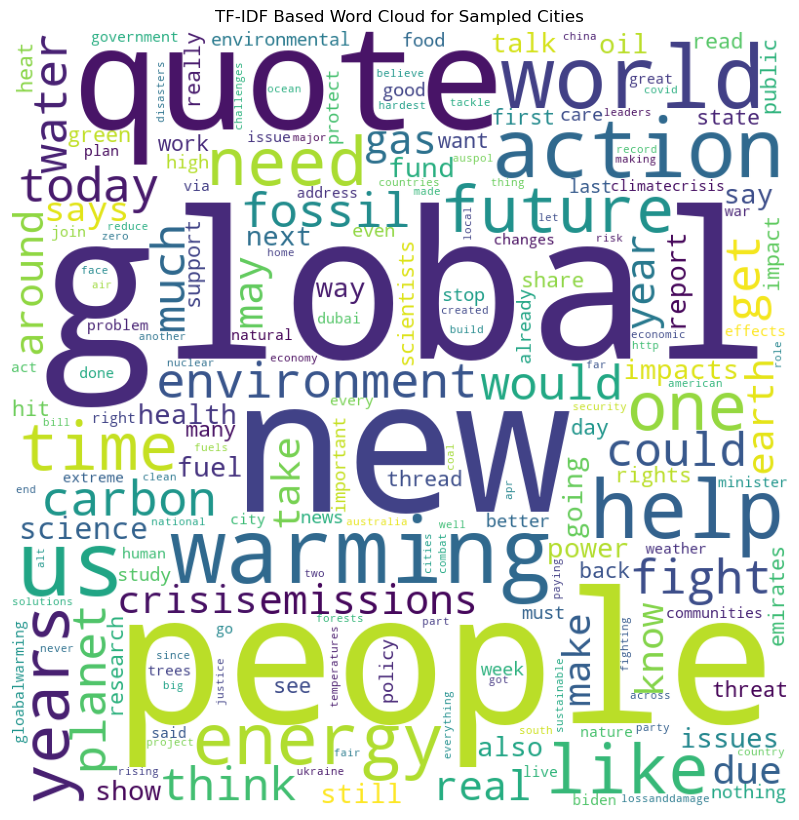

In [29]:
# Define stop words
stop_words = set(stopwords.words('english'))

# Define additional removable words
 # we know that they talk about climate change, so we are not interested in those words

list_removable = ['==', '===', '–', '"', '.', 'climate', 'change', 'climatechange',
                 'https', 'tweet', 'replying']
# Apply the cleaning function to the 'Text' column
tweets_df['cleaned_text'] = tweets_df['Text'].apply(clean_text_word_cloud)

# Tokenize and clean text for each city
for city in set(tweets_df.City):
    # Join all tweets text for each city and tokenize
    city_text = ' '.join(tweets_df[tweets_df.City == city]['Text'].dropna())
    tokens = nltk.word_tokenize(city_text)
    # Remove punctuation, convert to lower case, and filter out stopwords
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words and word not in list_removable]

    # Creating a frequency distribution
    fdist = nltk.FreqDist(tokens)
    
# Calculate Frequency Distribution
fdist = nltk.FreqDist(tokens)

# Combine text for each city and store in a dictionary
city_texts = {city: combine_text_for_city(city) for city in set(tweets_df.City.dropna())}

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(city_texts.values())

# Summing up the IDF (Inverse Document Frequency) of each term to get their importance
summed_tfidf = np.sum(tfidf_matrix, axis=0)
tfidf_scores = [(word, summed_tfidf[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
tfidf_scores = dict(tfidf_scores)

# Generate a word cloud based on TF-IDF scores
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(tfidf_scores)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.title('TF-IDF Based Word Cloud for Sampled Cities')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Here we confirm that these words are related to the topics found. 

## 8. Graph with *#*

In [31]:
# Re-running the mapping of users to hashtags
user_hashtags = defaultdict(set)

for index, row in tweets_df.iterrows():
    user = row['UserName']
    hashtags = extract_hashtags(row['Text'])
    for hashtag in hashtags:
        user_hashtags[user].add(hashtag)

# Create a list of edges
edges = []

# For each hashtag, create an edge between every pair of users who tweeted that hashtag
for hashtag, users in user_hashtags.items():
    edges.extend(combinations(users, 2))

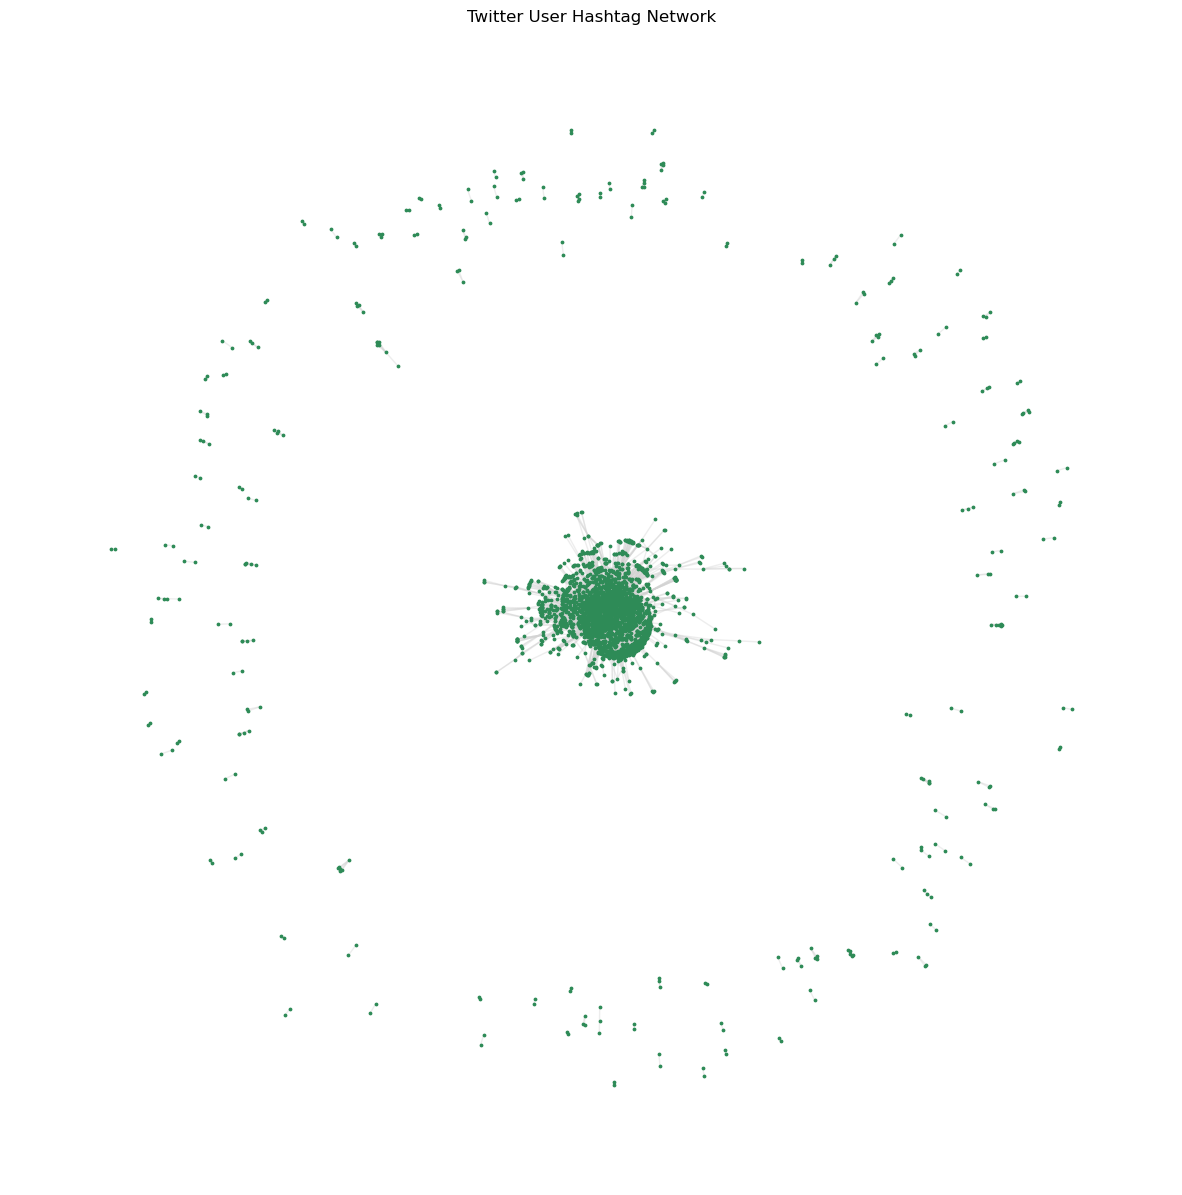

In [32]:
# Sample a subset of edges if the graph is too large
sample_size = 30000# Adjust this number based on the size and capability of your environment
sampled_edges = random.sample(edges, min(sample_size, len(edges)))

# Create a smaller graph with the sampled edges
G_sampled = nx.Graph()
G_sampled.add_edges_from(sampled_edges)

# Use the spring layout for better node distribution
pos = nx.spring_layout(G_sampled, seed=42)  # Seed for reproducible layout

# Calculate node degrees (number of connections)
degrees = dict(nx.degree(G_sampled))

# Draw the graph with node size proportional to degree and color by degree
plt.figure(figsize=(15, 15))
nodes = nx.draw_networkx_nodes(G_sampled, pos, node_size=3,
                               node_color='seagreen')
edges_draw = nx.draw_networkx_edges(G_sampled, pos, alpha=0.4,edge_color='lightgrey')
plt.axis('off')
plt.title('Twitter User Hashtag Network')
plt.show()

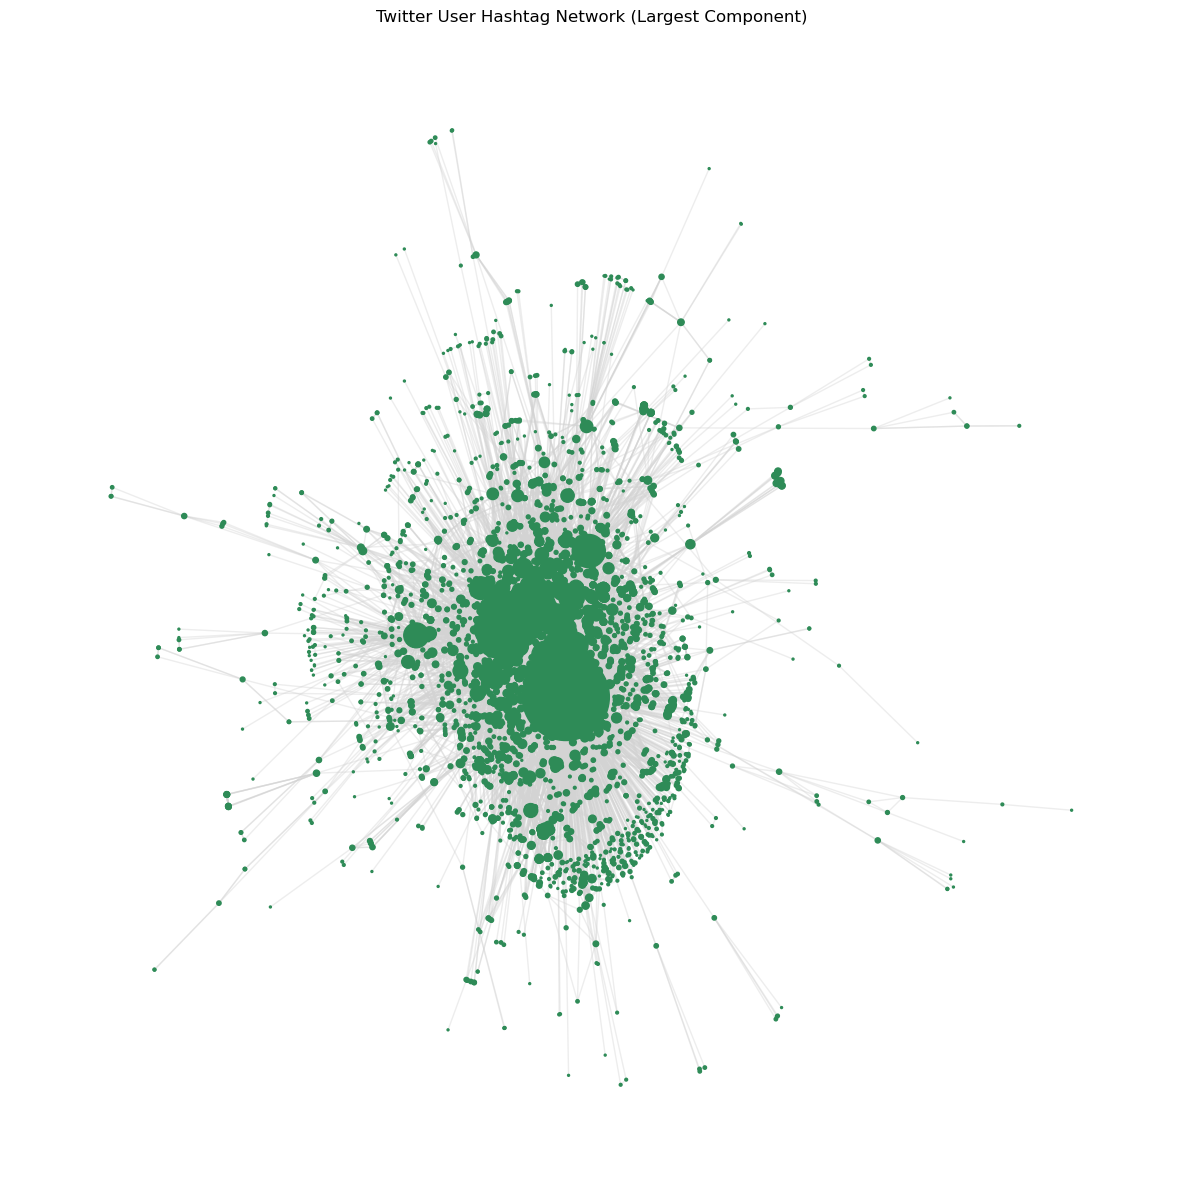

In [33]:
#extract connected components
connected_components = nx.connected_components(G_sampled)

# Get the largest connected component
largest_component = max(connected_components, key=len)

# Create a subgraph of the largest component
G_largest = G_sampled.subgraph(largest_component)

# Calculate node degrees (number of connections)
degrees = dict(nx.degree(G_largest))

# Draw the graph with node size proportional to degree and color by degree
plt.figure(figsize=(15, 15))
nodes = nx.draw_networkx_nodes(G_largest, pos, node_size=[v *2 for v in degrees.values()],
                               node_color='seagreen')
edges_draw = nx.draw_networkx_edges(G_largest, pos, alpha=0.4,edge_color='lightgrey')
plt.axis('off')
plt.title('Twitter User Hashtag Network (Largest Component)')
plt.show()

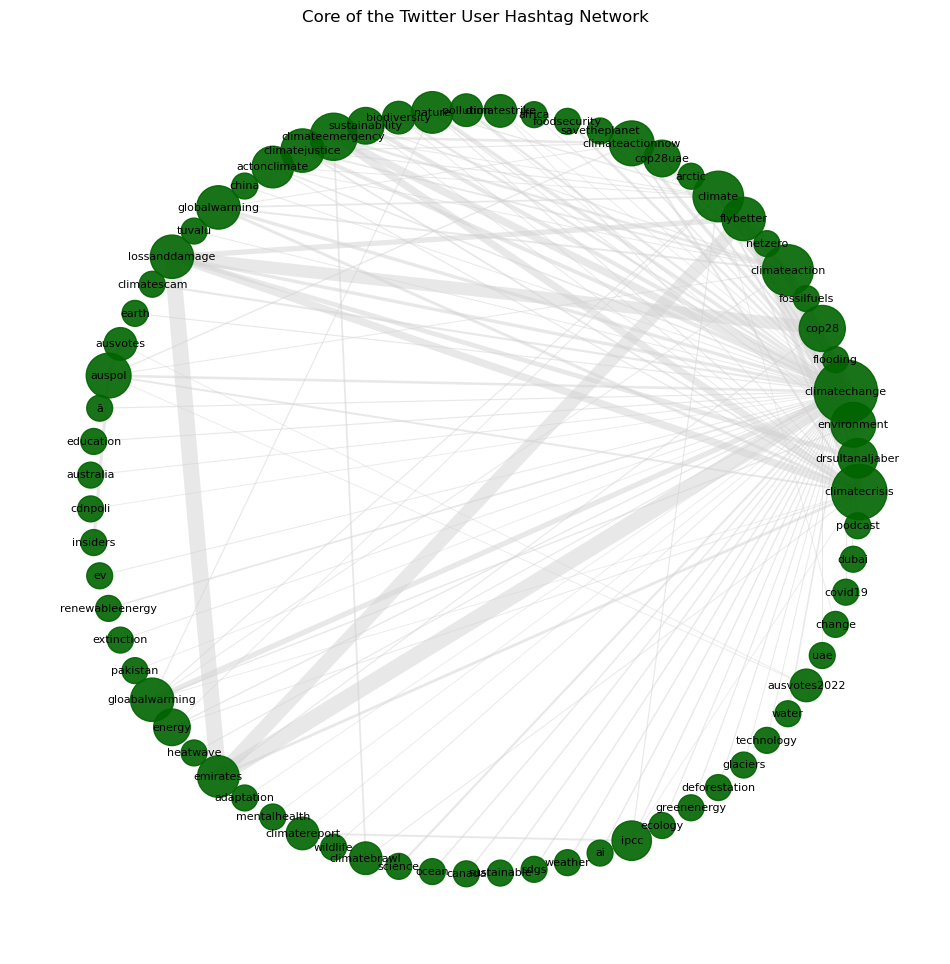

In [34]:
#get more frequent edges
weighted_edges=FreqDist(edges).most_common(150)
#shuffle weighted_edges
random.shuffle(weighted_edges)

#add weighted_edges to a graph 
G_wght = nx.Graph()

for edge in weighted_edges:
    G_wght.add_edge(edge[0][0],edge[0][1],weight=edge[1])

#pos = nx.spring_layout(G_wght, seed=42)  # Seed for reproducible layout



# Identify central nodes using betweenness centrality
centrality = nx.betweenness_centrality(G_wght)
# Sort nodes by centrality and pick the top N
top_central_nodes = sorted(centrality, key=centrality.get, reverse=True)[:50] 

# Create a subgraph around these central nodes
#H = G_wght.subgraph(top_central_nodes)
H = G_wght.subgraph(largest_component)


# Layout for better readability
original_pos = {'climatechange': ([-0.99068592, -0.1361667 ])}
#coordinate pair around which to center layout 
pos = nx.circular_layout(H,center=[0,-1],scale=0.05)

# Width 
edge_width = [float(d['weight'])/7 for u, v, d in H.edges(data=True)]
#color map
edge_cmap= plt.colormaps['Greens']

# Node size scaled so that degree 1 nodes have size 20 and degree 10 nodes have size 200
degrees = dict(nx.degree(H))
#node size in log scale
node_size = [np.log(v+1)*500 for v in degrees.values()]


# Visualization
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(H, pos, node_size=node_size, node_color='#006400',alpha=0.9)
#draw edges with width depending on weight 
nx.draw_networkx_edges(H, pos, alpha=0.5,edge_color='lightgrey',width=edge_width,)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.axis('off')
plt.title('Core of the Twitter User Hashtag Network')
plt.show()

* Node Size: Reflects the degree centrality of each user, with larger nodes indicating more connections.
* Node Color: Varied across a plasma color map based on clustering coefficients, providing a vivid representation of local clustering.
* Labels: Applied selectively to only the most central nodes, based on a higher centrality threshold, to reduce clutter and focus on key influencers.
* Edges: Made less prominent to direct attention primarily to the nodes.

## 9. Detecting communities

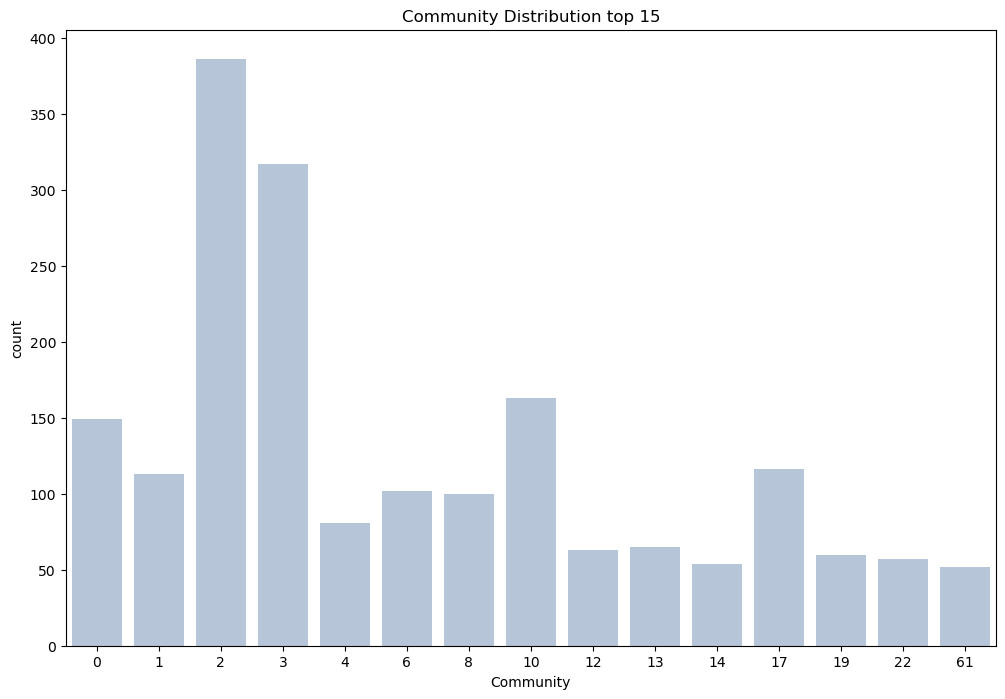

In [35]:
#extract connected components
connected_components = nx.connected_components(G_sampled)

# Get the largest connected component
largest_component = max(connected_components, key=len)

# Create a subgraph of the largest component
G_largest = G_sampled.subgraph(largest_component)

#get more frequent edges
weighted_edges=FreqDist(edges)
#shuffle weighted_edges
random.shuffle(weighted_edges)


G_com = G_largest.copy()

#add weights to G_com

for edge in G_com.edges():
    G_com[edge[0]][edge[1]]['weight']=weighted_edges[edge]
    
partition = detect_communities_louvain(G_com,resolution=1.0)

#transform partition to a dataframe
partition_df = pd.DataFrame.from_dict(partition, orient='index').reset_index()
partition_df.rename(columns={'index':'Hashtag', 0:'Community'}, inplace=True)

#because too many communities, we will only keep the top 15 communities
count_df = partition_df.groupby('Community').size().reset_index(name='Count')
count_select= count_df.sort_values(by='Count',ascending=False).head(15).reset_index(drop=True)
partition_df = partition_df[partition_df['Community'].isin(count_select['Community'])]

plt.figure(figsize=(12, 8))
sns.countplot(x='Community', data=partition_df,color='lightsteelblue')
plt.title('Community Distribution top 15')  
plt.show()

Our current objective is to incorporate community information into each tweet. Specifically, if a tweet includes a hashtag, we aim to append the corresponding community information associated with that hashtag to the tweet.

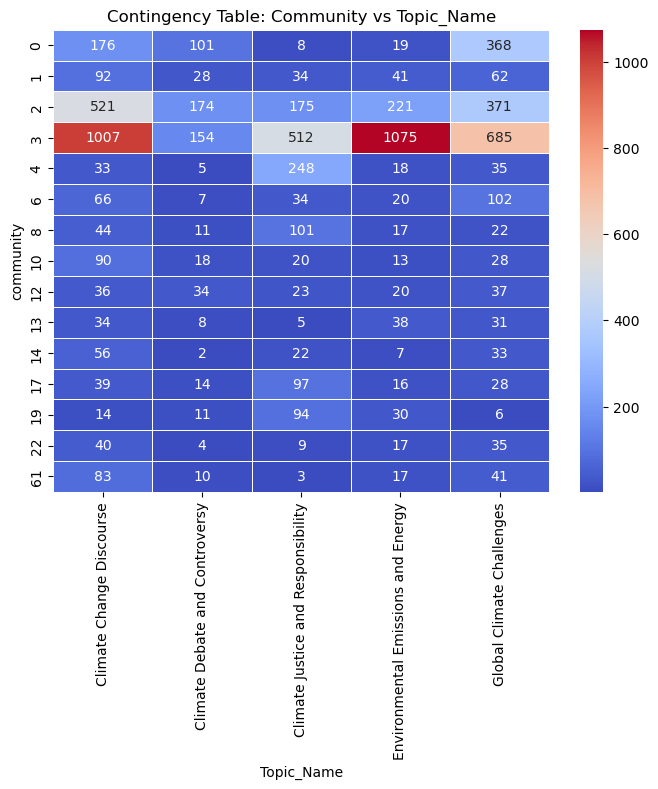

Chi-square value: 2422.9723159091404
Cramér's V: 0.27957181060935243


In [36]:
# Apply the function to create the 'community' column
tweets_cleaned['community'] = tweets_cleaned['Hashtags'].apply(map_to_community)

# For further analysis keep only rows that belong to a community
with_hashtags_df = tweets_cleaned[tweets_cleaned['Hashtags'].apply(lambda x: len(x) > 0)]

# Expand the dataset so that we have a row for each value of community, hence, a tweet can belong to one or more communities
df_exploded = with_hashtags_df.explode('community')
df_exploded = df_exploded[df_exploded['community'].notna()]

# Create a contingency table
contingency_table = pd.crosstab(df_exploded['community'], df_exploded['Topic_Name'])

# Perform chi-square test
chi2, _, _, _ = chi2_contingency(contingency_table)

# Calculate Cramér's V
n = contingency_table.sum().sum()
cramers_v = sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title('Contingency Table: Community vs Topic_Name')
plt.show()

print(f"Chi-square value: {chi2}")
print(f"Cramér's V: {cramers_v}")

Cramér's V is a measure of association between two categorical variables. Our Cramér's V value of 0.2299 is indicating a moderate association between the 'community' and 'Topic_Name' variables. This means that there is some tendency for certain communities to be associated with specific topics, but the association is not extremely strong.

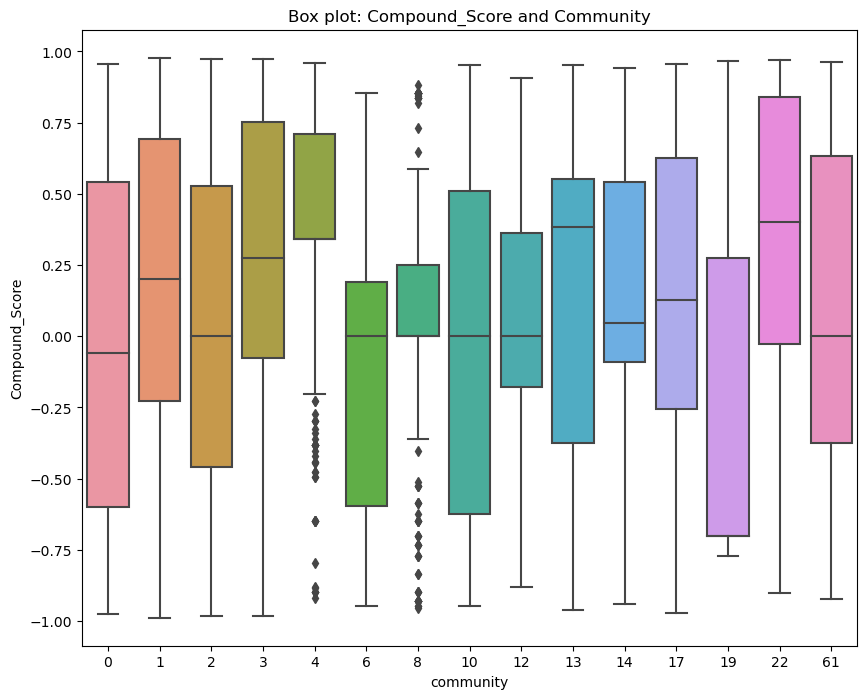

In [37]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='community', y='Compound_Score', data=df_exploded)
plt.title('Box plot: Compound_Score and Community')
plt.show()

We see that for some communities, the medians are more distant, for instance for community 15, which suggests a potential difference in the central tendency of sentiment scores. Also we see that some of the boxes are shorter, for instance for community 8 and 35 the box is way smaller than for the rest, which indicates variability differences in sentiment scores.
Finally, we there are not many outliers. However, the differences are not so noticeable, so we cannot say that there is a clear correlation between communities and sentiment score. 